# Analyzing the Birthplaces of NHL Players and Their Closest NHL Team

# Imports 

In [430]:
import pandas as pd
from functions import *
%run functions.py
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from haversine import haversine, Unit # I could have used geopy.distance, too
import scipy.stats as st
import numpy as np 
import pylab 
import mapclassify as mc
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

## Data

In [3]:
all_players_df = pd.read_csv('data/player_info_df.csv', index_col=0)
all_na_players_df = pd.read_csv('data/all_players_full_info.csv', index_col=0)

In [4]:
player_gdf = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf.drop(columns = ['link','Lat', 'Lng', 'geometry', 'nearest_geom', 'line'], inplace=True)

In [5]:
player_gdf.head(2)

,id,fullName,position,team_id,birthCity,birthStateProvince,birthCountry,nationality,team_name,city_province,coordinates,nearest_team,haversine_distance,close_to_any_team
0,8479414,Nathan Bastian,RW,1,Kitchener,ON,CAN,CAN,New Jersey Devils,"Kitchener,ON","43.4186,-80.4728",Toronto Maple Leafs,56.938564,True
1,8481740,Tyce Thompson,RW,1,Calgary,AB,CAN,CAN,New Jersey Devils,"Calgary,AB","51.05,-114.0667",Calgary Flames,1.076696,True


# Team Analysis

## How Many Players COULD Play for Closest Team

In [6]:
team_df = pd.DataFrame(player_gdf.groupby('nearest_team').id.count())

### Full teams

<AxesSubplot:xlabel='id'>

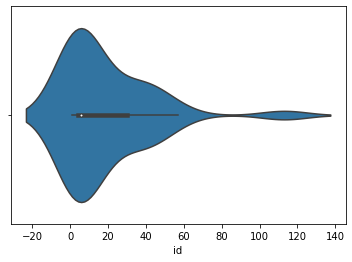

In [7]:
# distribution
sns.violinplot(x=team_df["id"])

In [8]:
# 11 teams would still be around!
# all 7 canadian teams plus one border team (Detroit, not Buffalo though)
team_df[team_df['id'] > 18].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


In [9]:
print(f"{round(all_na_players_df.shape[0] / all_players_df.shape[0], 2)*100}% of players are from NA")

69.0% of players are from NA


In [10]:
# A team roster has 18 players, normally
team_roster_count = player_gdf.shape[0] / player_gdf.team_name.nunique()

In [11]:
# Since 70% of players are from NA, how many teams have 70% of a roster? 13
## how many teams have more than 13 players born close to them? Same amount as before
team_df[team_df['id'] > 13].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


#### Are reasonably close

In [346]:
team_df_close = pd.DataFrame(player_gdf[player_gdf['close_to_any_team']==True].groupby('nearest_team').id.count())

In [347]:
# 8 teams have enough players born close to the team
team_df_close[team_df_close['id'] > 13].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,103
Detroit Red Wings,36
Vancouver Canucks,31
Montréal Canadiens,30
Minnesota Wild,26
Boston Bruins,23
Edmonton Oilers,18
Calgary Flames,17


## Few Players

In [12]:
# lots of teh southern teams have 5 or fewer players
# Every team has at least one NHL-quality player near them. That's frankly surprising
team_df[team_df['id'] < 13].sort_values(by='id')

,id
nearest_team,
San Jose Sharks,1
Vegas Golden Knights,1
Florida Panthers,1
Nashville Predators,2
Carolina Hurricanes,2
Tampa Bay Lightning,3
New Jersey Devils,4
Los Angeles Kings,4
Washington Capitals,4


# Players Playing for Home Team

In [13]:
home_team = player_gdf[player_gdf['team_name'] == player_gdf['nearest_team']]
# only 32 players play for their local team
print(home_team.shape[0])

32


In [14]:
# the Bruins and the Maples Leafs have the most hometown players
home_team_groupby = pd.DataFrame(home_team.groupby('team_name').id.count())
home_team_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,8
Boston Bruins,4
Detroit Red Wings,3
Minnesota Wild,3
Montréal Canadiens,3
Calgary Flames,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1


## Which team has the highest proportion of local players on their team?

In [15]:
# since the Maple Leafs have the most local players, it makes sense that they would have the most local players
## which team has the highest proportion of their local players on their team?
### divide values in home_team_groupby by values in closest team
teams_w_local_players = list(home_team_groupby.index)
team_df_w_local_players = team_df[team_df.index.isin(teams_w_local_players)]

In [16]:
home_team_groupby['Total_local_players_in_NHL'] = team_df_w_local_players
percent_of_local_players = round(home_team_groupby['id'] / 
                                 home_team_groupby['Total_local_players_in_NHL'], 2) * 100
home_team_groupby['Percent_of_local_players_on_team'] = percent_of_local_players
home_team_groupby.sort_values(by='Percent_of_local_players_on_team', ascending=False)

,id,Total_local_players_in_NHL,Percent_of_local_players_on_team
team_name,,,
Nashville Predators,1,2,50.0
Columbus Blue Jackets,1,4,25.0
Los Angeles Kings,1,4,25.0
Pittsburgh Penguins,1,7,14.0
Boston Bruins,4,40,10.0
Buffalo Sabres,1,12,8.0
Calgary Flames,2,29,7.0
Minnesota Wild,3,44,7.0
Montréal Canadiens,3,44,7.0


# How many players have their closest team being Seattle? 

In [329]:
# Seattle will have a new team in 2021
# the new arena's coordinates '47.622, -122.354'

# getting all players who have their closest team being in northwest
players_from_nw = player_gdf[player_gdf['nearest_team'].isin([
                                                             'Vancouver Canucks'])].reset_index(drop=True)

In [339]:
dist_to_seattle = [haversine([float(players_from_nw['coordinates'][idx].split(",")[0]), 
                              float(players_from_nw['coordinates'][idx].split(",")[1])],
                              [47.622, -122.354],unit=Unit.MILES) for idx in range(len(players_from_nw))]
close_to_seattle = [x for x in dist_to_seattle if x < 60]
# two players were born within 60 miles of seattle 
len(close_to_seattle)

2

# How many players are REASONABLY close and PLAYING for their NHL team?

In [17]:
# I'll define reasonably close as 60 miles away (as the crow flies)
## 394 players are very close to A team
very_close_players_df = player_gdf[player_gdf['haversine_distance'] < 60]
very_close_players_df.shape[0]

394

In [18]:
# 188 players are not reasonably close to any NHL team (in addition to the 30% of non-American players)
all_na_players_df.shape[0] - very_close_players_df.shape[0]

188

In [19]:
# how many players are close to THEIR team? 24
very_close_local_players_df = player_gdf[(player_gdf['haversine_distance'] < 60) & 
                                        (player_gdf['team_name'] == player_gdf['nearest_team'])]
very_close_local_players_df.shape[0]

24

In [20]:
# which teams have the most local players?
very_close_groupby = pd.DataFrame(very_close_local_players_df.groupby('team_name').id.count())
very_close_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,7
Boston Bruins,3
Minnesota Wild,3
Detroit Red Wings,2
Montréal Canadiens,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1
Edmonton Oilers,1


# Which States/Provinces Have the Most Players Per Capita?

## Engineering the Population Data

### US

In [240]:
# had to read files like this b/c it is xlsx file (https://stackoverflow.com/questions/65254535/xlrd-biffh-xlrderror-excel-xlsx-file-not-supported/65255334)
# I got the data from https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
us_pop_df = pd.read_excel(
    "data/nst-est2019-01.xlsx",
     engine='openpyxl', skiprows=3
)
us_pop_df2019 = us_pop_df[['Unnamed: 0', 2019]]
us_pop_df2019.columns = ['State_w_dot', 'Population'] # for 2019
us_pop_df2019.drop(index= us_pop_df2019.index[56:], inplace=True)
us_pop_df2019.drop(index= us_pop_df2019.index[:5], inplace=True)
us_pop_df2019['stateProvince'] = [x[1:] for x in us_pop_df2019['State_w_dot']]
us_pop_df2019['Country'] = 'USA'

In [241]:
# adding State Abbreviations
# from https://worldpopulationreview.com/states/state-abbreviations
us_abbrev = pd.read_csv("data/us_state_abbreviations.csv")

In [242]:
# adding state abbreviations to the data 
us_pop_df2019_abbrev = pd.merge(us_pop_df2019, us_abbrev, left_on='stateProvince', right_on='State')

### Canada

In [243]:
can_pop_df = pd.read_csv("data/1710000901-eng.csv", skiprows=5)
can_pop_df.drop(index= can_pop_df.index[15:], inplace=True)
can_pop_df.drop(index= can_pop_df.index[:2], inplace=True)
can_pop_df_2021 = can_pop_df[['Geography', 'Q1 2021']]
can_pop_df_2021.columns = ['Geography', 'Population']
can_pop_df_2021['Population'] = can_pop_df_2021['Population'].str.replace(',', '').astype(float)
can_pop_df_2021['stateProvince'] = [x[:-8] if "(map)" in x else x for x in can_pop_df_2021['Geography']]
can_pop_df_2021['Country'] = 'CAN'

In [244]:
# canadian abbreviations
can_abbrev = pd.read_excel("data/CountryCAN_e.xls")
can_abbrev['Province'] = [x.title() for x in can_abbrev['Province or Territory Name']]

In [245]:
# merging the two
can_pop_df_2021_abbrev = pd.merge(can_pop_df_2021, can_abbrev, left_on='stateProvince', right_on='Province')

### Merging the US and Canada Population data

In [246]:
us_can_pop_df_full = pd.concat([us_pop_df2019_abbrev, can_pop_df_2021_abbrev])

In [253]:
us_can_pop_df = us_can_pop_df_full[['Population', 'stateProvince', 'Code', 'Country']]

## Combining with the Player Data

In [254]:
player_province_data = pd.DataFrame(player_gdf.groupby('birthStateProvince').id.count())

In [255]:
us_can_player_pop_df = pd.merge(us_can_pop_df, player_province_data, 
                                left_on=['Code'], right_on=['birthStateProvince'])

In [259]:
us_can_player_pop_df.columns = ['Population', 'stateProvince', 'Code', 'Country', 'NHL_players']

In [287]:
# standardizing how many players there are per 100k inhabitants
us_can_player_pop_df['Players_100k_people'] = round((us_can_player_pop_df['NHL_players'] / us_can_player_pop_df['Population']) * 100000, 2) 

## Analyzing Players Per Capita

In [288]:
# keeping only the 41 states and provinces with players
us_can_player_pop_df.sort_values(by='Players_100k_people', ascending=False, inplace=True)
us_can_player_pop_df.shape

(41, 6)

In [356]:
us_can_player_pop_df[us_can_player_pop_df['Country']=='USA']

,Population,stateProvince,Code,Country,NHL_players,Players_100k_people
14,5639632.0,Minnesota,MN,USA,34,0.60
13,9986857.0,Michigan,MI,USA,34,0.34
12,6892503.0,Massachusetts,MA,USA,23,0.33
31,5822434.0,Wisconsin,WI,USA,11,0.19
10,1344212.0,Maine,ME,USA,2,0.15
5,3565287.0,Connecticut,CT,USA,5,0.14
1,731545.0,Alaska,AK,USA,1,0.14
21,762062.0,North Dakota,ND,USA,1,0.13
20,19453561.0,New York,NY,USA,25,0.13
19,8882190.0,New Jersey,NJ,USA,10,0.11


<AxesSubplot:xlabel='Players_100k_people', ylabel='Code'>

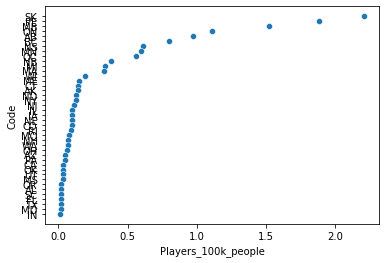

In [289]:
# plotting all states. Big disparity here!
sns.scatterplot(x = us_can_player_pop_df['Players_100k_people'], y = us_can_player_pop_df['Code'])

In [345]:
# Canadian provinces
us_can_player_pop_df[us_can_player_pop_df['Country'] == 'CAN']

,Population,stateProvince,Code,Country,NHL_players,Players_100k_people
38,1178832.0,Saskatchewan,SK,CAN,26,2.21
32,159819.0,Prince Edward Island,PE,CAN,3,1.88
37,1380935.0,Manitoba,MB,CAN,21,1.52
36,14755211.0,Ontario,ON,CAN,164,1.11
39,4436258.0,Alberta,AB,CAN,43,0.97
40,5153039.0,British Columbia,BC,CAN,41,0.80
33,979449.0,Nova Scotia,NS,CAN,6,0.61
35,8575944.0,Quebec,QC,CAN,48,0.56
34,782078.0,New Brunswick,NB,CAN,3,0.38


In [304]:
# Plotting the top 20 states/provinces
top20_us_can_player_pop_df = us_can_player_pop_df.iloc[0:20].reset_index(drop=True)

In [359]:
top20_us_can_player_pop_df.head()

,Population,stateProvince,Code,Country,NHL_players,Players_100k_people
0,1178832.0,Saskatchewan,SK,CAN,26,2.21
1,159819.0,Prince Edward Island,PE,CAN,3,1.88
2,1380935.0,Manitoba,MB,CAN,21,1.52
3,14755211.0,Ontario,ON,CAN,164,1.11
4,4436258.0,Alberta,AB,CAN,43,0.97


In [308]:
# The average Saskatchewanian is 17 times more likely to play in the nhl than the average New Yorker
top20_us_can_player_pop_df['Players_100k_people'][0] / top20_us_can_player_pop_df['Players_100k_people'][17]

17.0

Text(0.5, 1.0, 'Number of NHL Players per 100,000 People in US and Canadian States and Provinces')

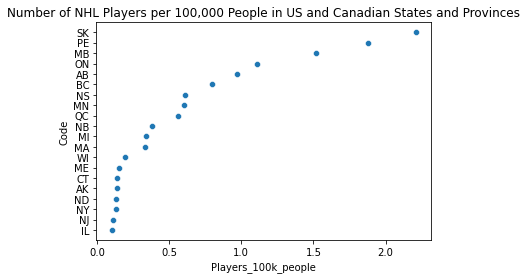

In [343]:
# viewing the top 20 states/provinces
ax = sns.scatterplot(x = top20_us_can_player_pop_df['Players_100k_people'], y = top20_us_can_player_pop_df['Code'])
ax.set_title("Number of NHL Players per 100,000 People in US and Canadian States and Provinces")

## Analyzing the distribution of NHL Players per Capita

In [363]:
# all of the players per capita data
get_best_distribution(us_can_player_pop_df['Players_100k_people'])

p value for weibull_min = 0.0006155886527747789
p value for norm = 0.0003441041288074239
p value for weibull_max = 0.0007239539168466536
p value for beta = 0.006494879364701278
p value for invgauss = 0.8550894596715332
p value for uniform = 4.961625710643186e-16
p value for gamma = 0.10365328927532713
p value for expon = 0.00021942200875079275
p value for lognorm = 0.8518505142812023
p value for pearson3 = 0.5150354604868983
p value for triang = 8.26193540665083e-13
Best fitting distribution: invgauss
Best p value: 0.8550894596715332
Parameters for the best fit: (5.636388891321917, 0.002293259196406607, 0.05766458281271529)


('invgauss',
 0.8550894596715332,
 (5.636388891321917, 0.002293259196406607, 0.05766458281271529))

In [364]:
# the top 20 players per capita states/provinces
get_best_distribution(top20_us_can_player_pop_df['Players_100k_people'])

p value for weibull_min = 0.6434388671862814
p value for norm = 0.3158559878167717
p value for weibull_max = 0.0002068159679842505
p value for beta = 0.26623912733292643
p value for invgauss = 0.4229777197426261
p value for uniform = 0.00023165876957990554
p value for gamma = 0.24080337852533684
p value for expon = 0.11516811073786781
p value for lognorm = 0.6985241904260874
p value for pearson3 = 0.3383548661674437
p value for triang = 0.023467949521417397
Best fitting distribution: lognorm
Best p value: 0.6985241904260874
Parameters for the best fit: (1.7555309074414027, 0.0969599860502845, 0.1862536300672426)


('lognorm',
 0.6985241904260874,
 (1.7555309074414027, 0.0969599860502845, 0.1862536300672426))

### Plotting the distributions

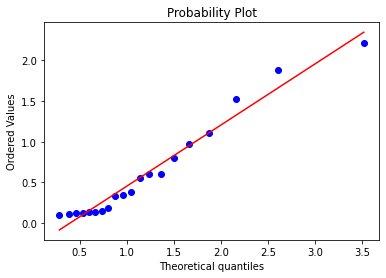

In [380]:
st.probplot(top20_us_can_player_pop_df['Players_100k_people'], dist=st.lognorm(0.69), plot=pylab)
pylab.show()

# Mapping states by Players per capita

In [383]:
n_am_gdf = gpd.read_file("data/Political_Boundaries_(Area)/Political_Boundaries_(Area).shp")

In [411]:
us_can_gdf = n_am_gdf[n_am_gdf['COUNTRY'].isin(['CAN', 'USA'])]
us_can_gdf_dissolved = us_can_gdf.dissolve('NAME')
us_can_gdf_dissolved2 = us_can_gdf_dissolved[us_can_gdf_dissolved.STATEABB.notnull()]

us_can_gdf_dissolved2['ABB'] = [x[-2:] for x in us_can_gdf_dissolved2['STATEABB']]

us_can_gdf_dissolved3 = pd.merge(us_can_gdf_dissolved2, us_can_player_pop_df, left_on='ABB', right_on='Code')

## Choropleth

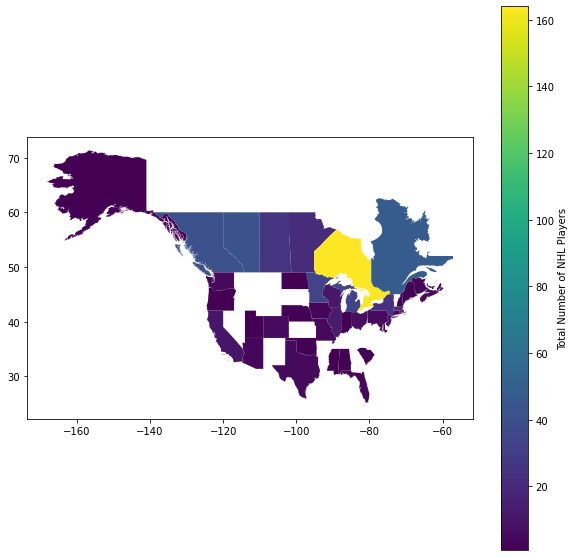

In [441]:
us_can_gdf_dissolved3.plot(column = 'NHL_players', figsize=(10, 10), legend=True,
                  legend_kwds={'label':"Total Number of NHL Players"})
# plt.savefig("pictures/province_state_choropleth.png", bbox_inches='tight', pad_inches=0.2)

<AxesSubplot:>

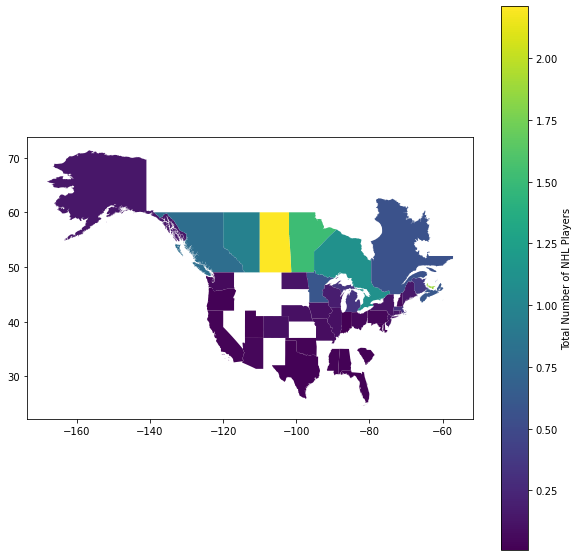

In [452]:
us_can_gdf_dissolved3.plot(column = 'Players_100k_people', figsize=(10, 10), legend=True,
                  legend_kwds={'label':"Total Number of NHL Players"})

## Cartogram

In [426]:
# had to change the projection of it to work
us_can_gdf_dissolved3.to_crs("EPSG:4326", inplace=True)

Text(0.5, 1.0, 'Basic Cartogram of NA States/Provinces NHL Player Ration')

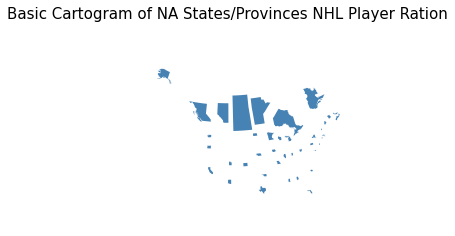

In [432]:
gplt.cartogram(us_can_gdf_dissolved3, scale='Players_100k_people', 
               projection=gcrs.AlbersEqualArea(), figsize=(7,7))
plt.title("Basic Cartogram of NA States/Provinces NHL Player Ratio", fontdict={"fontsize":15})

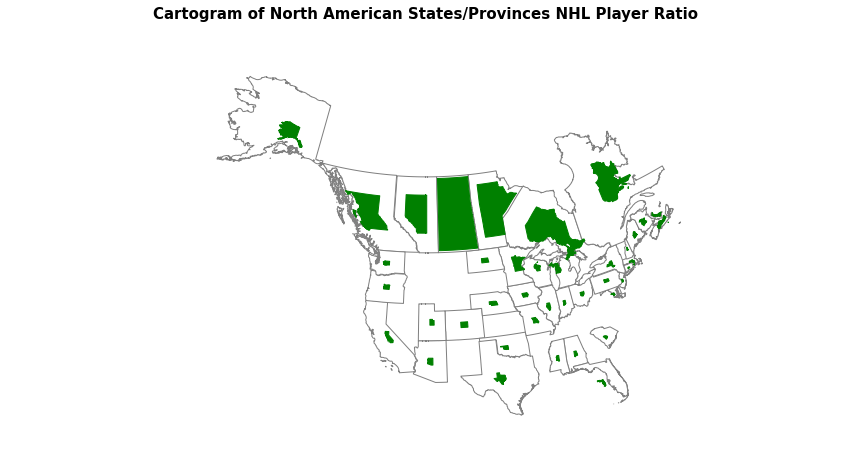

In [451]:
ax1 = gplt.cartogram(us_can_gdf_dissolved3, scale='Players_100k_people', projection=gcrs.AlbersEqualArea(), 
                     figsize=(15,15), limits=(0.15, 0.95), color = 'green')
gplt.polyplot(us_can_gdf_dissolved3, facecolor='white', edgecolor='grey', ax=ax1)
ax1.set_title("Cartogram of North American States/Provinces NHL Player Ratio", 
              fontdict={"fontsize":15, 'fontweight':'bold'})
plt.savefig("pictures/province_state_cartogram.png")
# , bbox_inches='tight', pad_inches=1